In [2]:
# ---------------------------------------------
# IMPORT LIBRARIES
# ---------------------------------------------
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN 
from sklearn.neighbors import radius_neighbors_graph
import torch_geometric_temporal.signal.static_graph_temporal_signal as SGTS
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tqdm import tqdm

# ---------------------------------------------
# DEFINE MODEL ARCHITECTURE
# - 
# - Relu 
# - Fully connected layer 
# ---------------------------------------------
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, forecast_len):
        super(RecurrentGCN, self).__init__()
        self.recurrent1 = DCRNN(node_features, 32, 1, True)
        self.linear1 = torch.nn.Linear(32, forecast_len) #(features from conv, output dimension)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent1(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear1(h)
        return h

# ---------------------------------------------
# LOAD DATA
# **************** USER INPUT *****************
# input the range of clusters 
# --------------------------------------------- 
cluster_id = 12

data_path = '/Users/muneeza/Documents/GitHub/DATA_SMest/'

# Set description variables
sub_feat_names = ['AREA', 'PRECIP' , 'ET', 'SW_END', 'PERC', 'GW_RCHG', 'DA_RCHG', 'REVAP', 'SA_IRR', 'DA_IRR', 'SA_ST', 'DA_ST',
                 'WYLD', 'DAILYCN', 'TMP_AV', 'SOL_TMP', 'SOLAR']

test_mse = []
pers_mse = []
rel_err = []
for cluster in range(cluster_id):
    # ---------------------------------------------
    # READ PRE-PROCESSED DATA FOR THE CLUSTER 
    # this data contains a subset of informative features
    # for a subsample of hrus for the given cluster
    # data shape :  (timesteps, hrus, features )
    # ---------------------------------------------
    clstr_distance = np.load(data_path+'HRU_Clustering_results/'+'dist.in.cluster_'+str(cluster)+'.npy')
    data = np.load(data_path+'sub_hru_sub_data_clstr_'+str(cluster)+'.npy')

    # Select id for target variable 
    target_id = sub_feat_names.index('SW_END')


    # ---------------------------------------------
    # TEST TRAIN SPLIT
    # train : first 27 years
    # test : year 27-34  
    # discard end 2 years 
    # --------------------------------------------- 
    train_id_en = 27*12
    test_id_en = 34*12 
    X_train = data[0:train_id_en, :, :]
    X_test = data[train_id_en:test_id_en, :, :]


    # ---------------------------------------------
    # NORMALIZE TEST AND TRAIN DATA SEPERATELY 
    # X (n_ts , sz, d) 
    # n_ts : number of time series (hrus)
    # sz : size of time series (n time steps)
    # d : dimension of data (n features)
    # CAUTION !! data shape for normalization must be (hrus , timesteps , features )
    # ---------------------------------------------
    X_train = TimeSeriesScalerMinMax(value_range=(0,1)).fit_transform( np.transpose(X_train,(1,0,2)) )
    X_test = TimeSeriesScalerMinMax(value_range=(0,1)).fit_transform( np.transpose(X_test,(1,0,2)) )
    X_train = np.transpose(X_train, (1,0,2) ) # reshape back to original 
    X_test = np.transpose(X_test, (1,0,2) ) # reshape back to original 


    # ---------------------------------------------
    # GENERATE LABELS FOR SEQUENCE PREDICTION 
    # X shape : (timesteps, hrus, features )
    # Y shape : (timesteps, hrus, seq_len )
    # --------------------------------------------- 
    seq_len = 1
    n_feat = len(sub_feat_names)
    n_hrus = X_train.shape[1]
    test_len = X_test.shape[0]

    Y_train = np.zeros((train_id_en - seq_len , n_hrus, seq_len))
    Y_test = np.zeros((test_len - seq_len , n_hrus, seq_len))

    # For data X at time T, the prediction Y is
    # Y[T] = X[T+1 : T+seq_len]
    for i in range(train_id_en - seq_len):
        Y_train[i, : , :] = X_train[i+1:i+1+seq_len  , : , target_id ].T
    for i in range(1 , test_len - seq_len):    
        Y_test[i-1, : , :] = X_test[i:i+seq_len , : , target_id].T

    # Remove the last seq_len values from X 
    # since their corresponding forecast sequences 
    # arnt available.      
    X_train = X_train[0:train_id_en-seq_len , : , :  ]
    X_test = X_test[0:test_len-seq_len , : , : ]


    # ---------------------------------------------
    # GENERATE STATIC GRAPH STRUCTURE
    # ---------------------------------------------
    adj_csr = radius_neighbors_graph( clstr_distance, 1, include_self = True)

    # Adjacency matrix to edge list for PyG Data structure 
    adj_coo = np.transpose(adj_csr).tocoo()
    row = torch.tensor(adj_coo.row)
    col = torch.tensor(adj_coo.col) 
    edge_attr = torch.tensor(adj_coo.data).type(torch.float)
    edge_index = torch.stack([row, col], dim=0).type(torch.long)


    # ---------------------------------------------
    # GENERATE TEMPORAL GRAPH DATA
    # Shape for graph data :  (timeseries, hrus , features )
    # ---------------------------------------------
    train_dataset = SGTS.StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=edge_attr, features=X_train, targets=Y_train)
    test_dataset = SGTS.StaticGraphTemporalSignal(edge_index=edge_index, edge_weight=edge_attr, features=X_test, targets=Y_test)


    # ---------------------------------------------
    # TRAIN MODEL 
    # Hyperparameters: 
    # - learning rate (lr) = 0.01
    # - weights initialization 
    # - epochs - early stopping 
    # ---------------------------------------------
    epochs = 10
    model = RecurrentGCN(node_features = n_feat, forecast_len = seq_len )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    hist = []
    for ep in tqdm(range(epochs)):
        cost = 0
        for time, snapshot in enumerate(train_dataset):
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)
        cost = cost / (time+1)
        hist.append(cost.item())
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()


    # ---------------------------------------------
    # MODEL EVALUATION
    # ---------------------------------------------
    model.eval()
    cost = 0
    for time, snapshot in enumerate(test_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    test_mse.append(cost.item())
    print("Clustering + TGCN MSE: {:.3f}".format(test_mse[cluster]))


    # ---------------------------------------------
    # NAÏVE MODEL
    # SM Forecast at time T is the average of 
    # previous SM values {T-1 , .. , T-n}.
    # ---------------------------------------------
    mse=[]
    for i in range (seq_len):
        mse.append(np.mean((X_test[:,:, target_id] - Y_test[:,:,i])**2))
    pers_mse.append(np.sum(np.array(mse)))
    print('Persistence MSE : {:.3f}'.format(pers_mse[cluster]) )
    rel_err.append((pers_mse[cluster] - test_mse[cluster])*100/(pers_mse[cluster]))
    print('Relative MSE reduction using TGNN: {:.2f}%'.format(rel_err[cluster]))

print("Clustering + TGCN Mean MSE on test data: {:.4f}".format( np.mean(np.array(test_mse)) ))
print("Clustering + TGCN Var MSE on test data: {:.4f}".format( np.var(np.array(test_mse)) ))
print("Naïve model Mean MSE on test data: {:.4f}".format( np.mean(np.array(pers_mse)) ))
print("Naïve model Var MSE on test data: {:.4f}".format( np.var(np.array(pers_mse)) ))

100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


IndexError: list index out of range

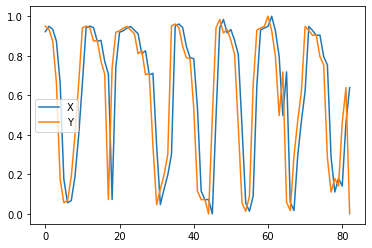

In [12]:
# # ---------------------------------------------
# # VISUALIZE FOR SANITY 
# # Y should be 1 timestep lagged compared to X
# # --------------------------------------------- 
# import matplotlib.pyplot as plt
# plt.plot(X_test[:, 16, target_id], label = 'X')
# plt.plot(Y_test[:, 16, : ], label ='Y')
# plt.legend()
